In [2]:
# Setup environment
# Set CRAN mirror explicitly for knitting
options(repos = c(CRAN = "https://cloud.r-project.org"))

# Install and load necessary packages if not availables
packages <- c("tidyverse", "sf", "ggplot2", "readxl", "dplyr", "ggrepel", "scales", "rmarkdown")
for (pkg in packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

Loading required package: rmarkdown



# Children in Child Care Institutions
## A Fact File

In West Bengal, presently there are 56 Govt. run Units of Home including 8 units for Child in Conflict with Law and 75 NGO run Units of Home including 6 units for CCL functioning under the umbrella of Mission Vatsalya.

Reading layer `District_shape_West_Bengal' from data source 
  `/home/kiran/annual_report_scps/input/west-bengal-district-shape-files/District_shape_West_Bengal.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 24 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 85.82636 ymin: 21.53945 xmax: 89.87755 ymax: 27.22103
Geodetic CRS:  WGS 84


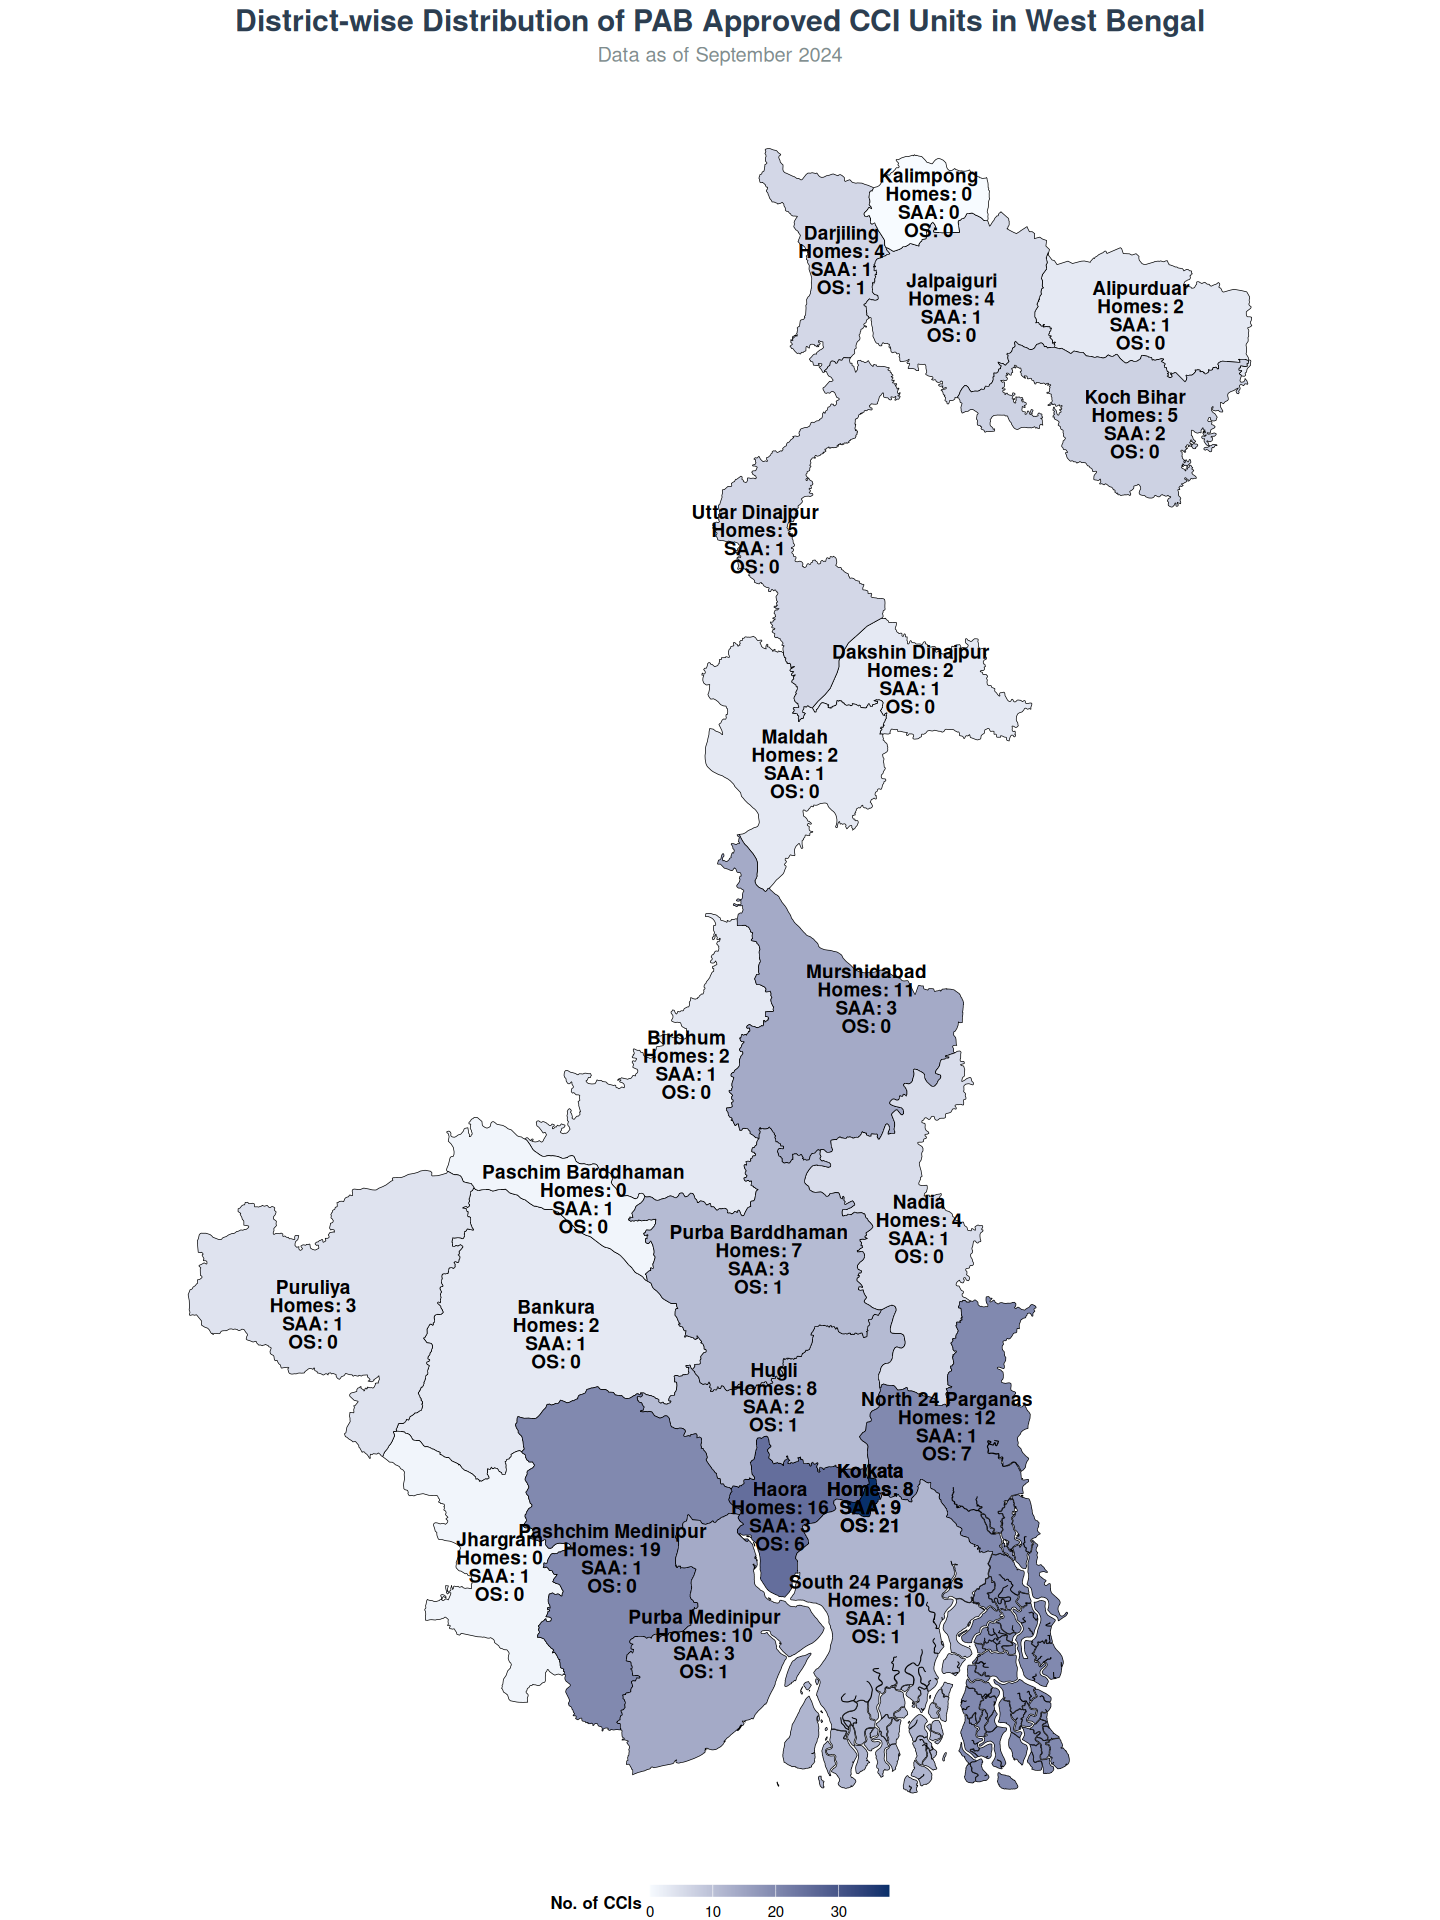

In [5]:
# Data file path
data_file <- "../input/children-in-cci/2024-09-22_Data.xlsx"

# Map file path
shp_file <- "../input/west-bengal-district-shape-files/District_shape_West_Bengal.shp"

# Read the Excel file (assuming the file is in the working directory)
df_cci_count <- read_excel(data_file, sheet = "CCI_Count")

# Load the shapefile for West Bengal
west_bengal_map <- st_read(shp_file)

# Merge the West Bengal map with the CCI data
merged <- merge(west_bengal_map, df_cci_count, by.x = "NAME", by.y = "District")

# Calculate the "Homes" total and create a custom label for each district
merged <- merged %>%
  mutate(
    Homes =
      `Children Home` +
        `Children Home CWSN` +
        `Observation Home` +
        `Special Home/ Place of Safety`, # Sum of relevant columns
    Label = paste0(
      NAME, "\n", # District name
      "Homes: ", Homes, "\n", # Homes total
      "SAA: ", `Specialized Adoption Agency`, "\n", # SAAs
      "OS: ", `Open Shelter` # OSs
    )
  )

# Reproject the data to UTM Zone 45N (EPSG:32645)
merged_projected <- st_transform(merged, 32645)

# Set the figure size
options(repr.plot.width = 12, repr.plot.height = 16)

ggplot(data = merged_projected) +
  geom_sf(aes(fill = Total), color = "black", size = 0.3) +
  geom_sf_text(
    aes(label = Label),
    color = "black",
    size = 4,
    fontface = "bold",
    lineheight = 0.8,
    check_overlap = FALSE
  ) +
  scale_fill_gradient(
    low = "#f7fbff",
    high = "#08306b",
    name = "No. of CCIs",
    guide = guide_colorbar(barwidth = 10, barheight = 0.5)
  ) +
  theme_void() +
  theme(
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA),
    legend.position = "bottom",
    legend.title = element_text(size = 10, face = "bold"),
    legend.text = element_text(size = 9),
    plot.title = element_text(
      hjust = 0.5,
      size = 18,
      face = "bold",
      color = "#2c3e50"
    ),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "#7f8c8d"),
  ) +
  labs(
    title = "District-wise Distribution of PAB Approved CCI Units in West Bengal",
    subtitle = "Data as of September 2024",
    fill = "No. of CCIs"
  )

# Print the map
# ggsave("district_wise_cci_map_R.png", width = 8.27, height = 11.69, dpi = 300)


As on 31st March 2023 a total of 4148 inmates among different categories are being facilitated in the above-mentioned homes.

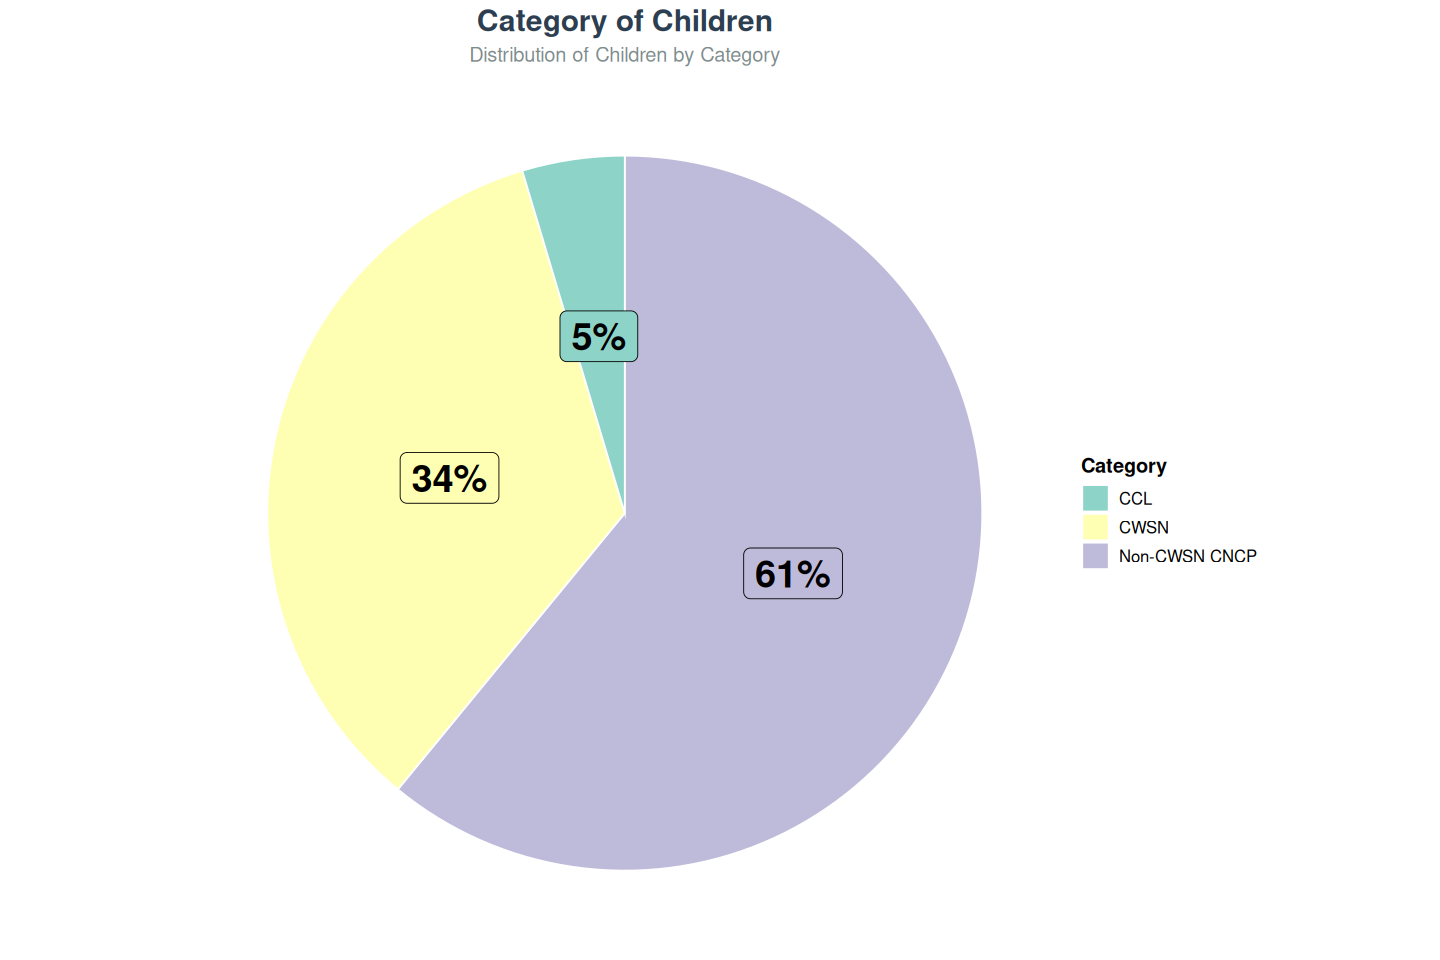

In [6]:
# Read the Excel file with sheet name specified (assuming the file is in the working directory)
df_child_category <- read_excel(data_file, sheet = "Child_Category")

# Calculate percentage of occupancy
df_child_category <- df_child_category %>%
  mutate(perc = `No. of Children` / sum(`No. of Children`)) %>%
  mutate(labels = scales::percent(perc))

# Set the figure size
options(repr.plot.width = 12, repr.plot.height = 8)

# Create the pie chart
ggplot(df_child_category, aes(x = "", y = `No. of Children`, fill = Category)) +
  geom_bar(stat = "identity", width = 1, color = "white") + # Add white borders for clarity
  coord_polar("y", start = 0) +
  theme_void() + # Use a minimal theme
  geom_label(
    aes(label = labels),
    position = position_stack(vjust = 0.5),
    size = 8, # Increase label size
    color = "black", # White text for better contrast
    fontface = "bold", # Bold text
    show.legend = FALSE # Hide labels from legend
  ) +
  scale_fill_brewer(palette = "Set3") + # Use a colorblind-friendly palette
  labs(
    title = "Category of Children",
    subtitle = "Distribution of Children by Category", # Add a subtitle
    fill = "Category" # Legend title
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold", color = "#2c3e50"), # Customize title
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "#7f8c8d"), # Customize subtitle
    plot.caption = element_text(hjust = 1, size = 10, color = "#7f8c8d"), # Customize caption
    legend.position = "right", # Place legend on the right
    legend.title = element_text(size = 12, face = "bold"), # Customize legend title
    legend.text = element_text(size = 10) # Customize legend text
  )


During FY 2020-21, due to COVID-19 pandemic, number of children facilitated through Mission Vatsalya, erstwhile CPS was declined but this improved in the following years.

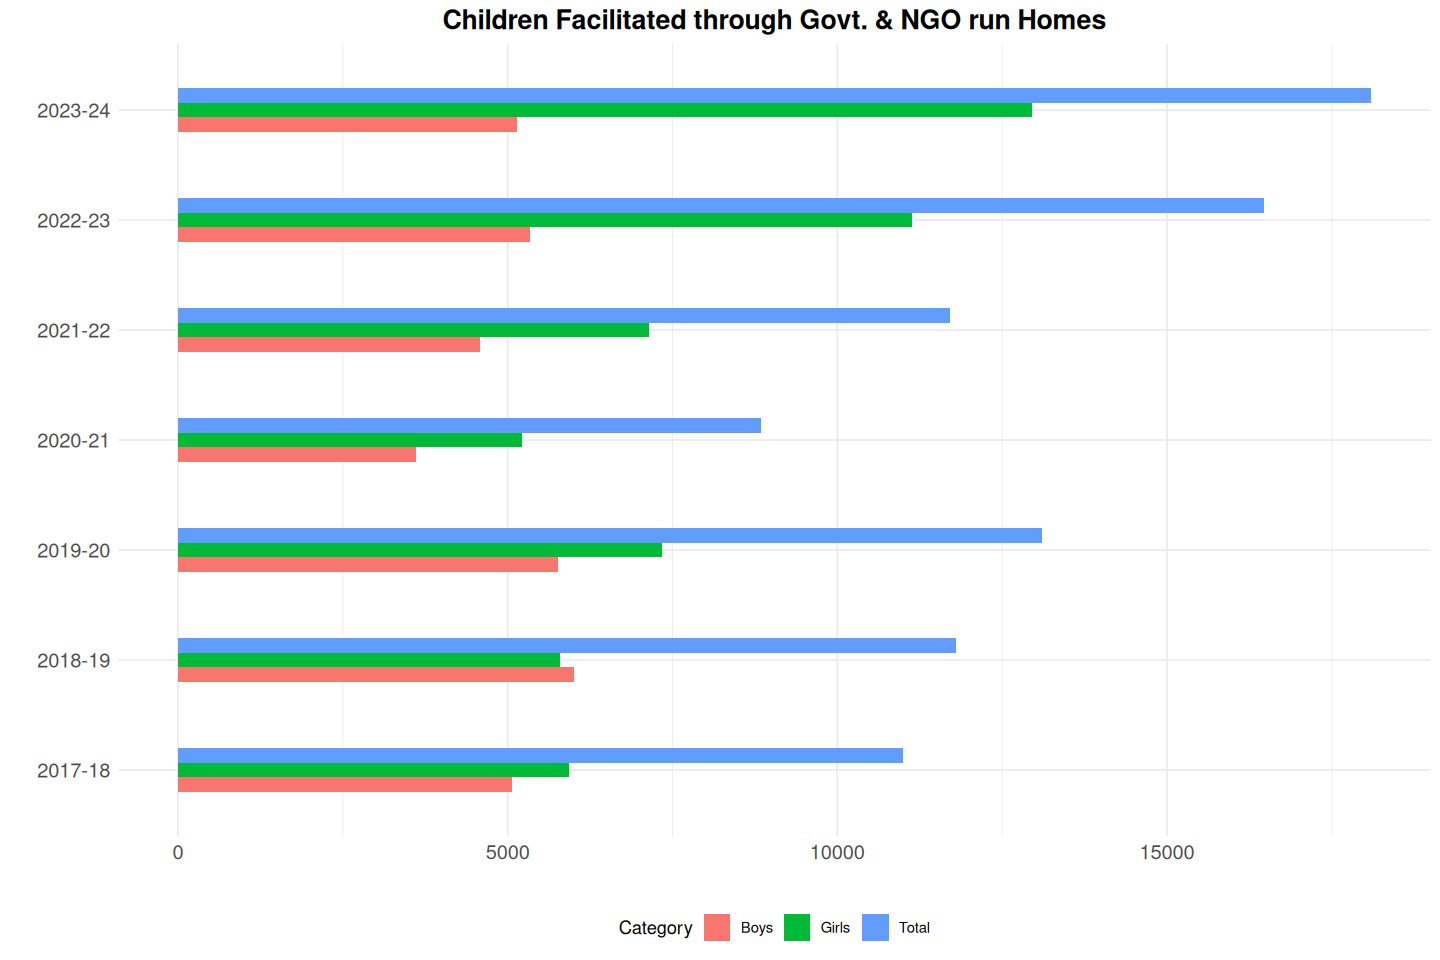

In [7]:
# Read the excel file with sheet name for children under purview
df_child_purview <- read_excel(data_file, sheet = "PurviewCCI")

# Reshape the data for ggplot2 (convert to long format)
df_long <- df_child_purview %>%
  pivot_longer(cols = c(Girls, Boys, Total), names_to = "Category", values_to = "Count")

# Create the bar chart
ggplot(df_long, aes(x = as.factor(FY), y = Count, fill = Category)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.4) + # Use "dodge" to place bars side by side
  coord_flip() +
  labs(
    title = "Children Facilitated through Govt. & NGO run Homes",
    x = "",
    y = "",
    fill = "Category"
  ) +
  theme_minimal() + # Use a minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"), # Center and style the title
    axis.text.x = element_text(size = 12), # Adjust x-axis text size
    axis.text.y = element_text(size = 12), # Adjust y-axis text size
    legend.position = "bottom" # Place the legend at the top
  )


Enrollment in Formal Education has also improved during this financial year as more non-CWSN CNCP children are enrolled with the formal education system through NIOS. Children with Special Needs who are unable to be enrolled in formal system are getting special education through Special Educators engaged at the CCI.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


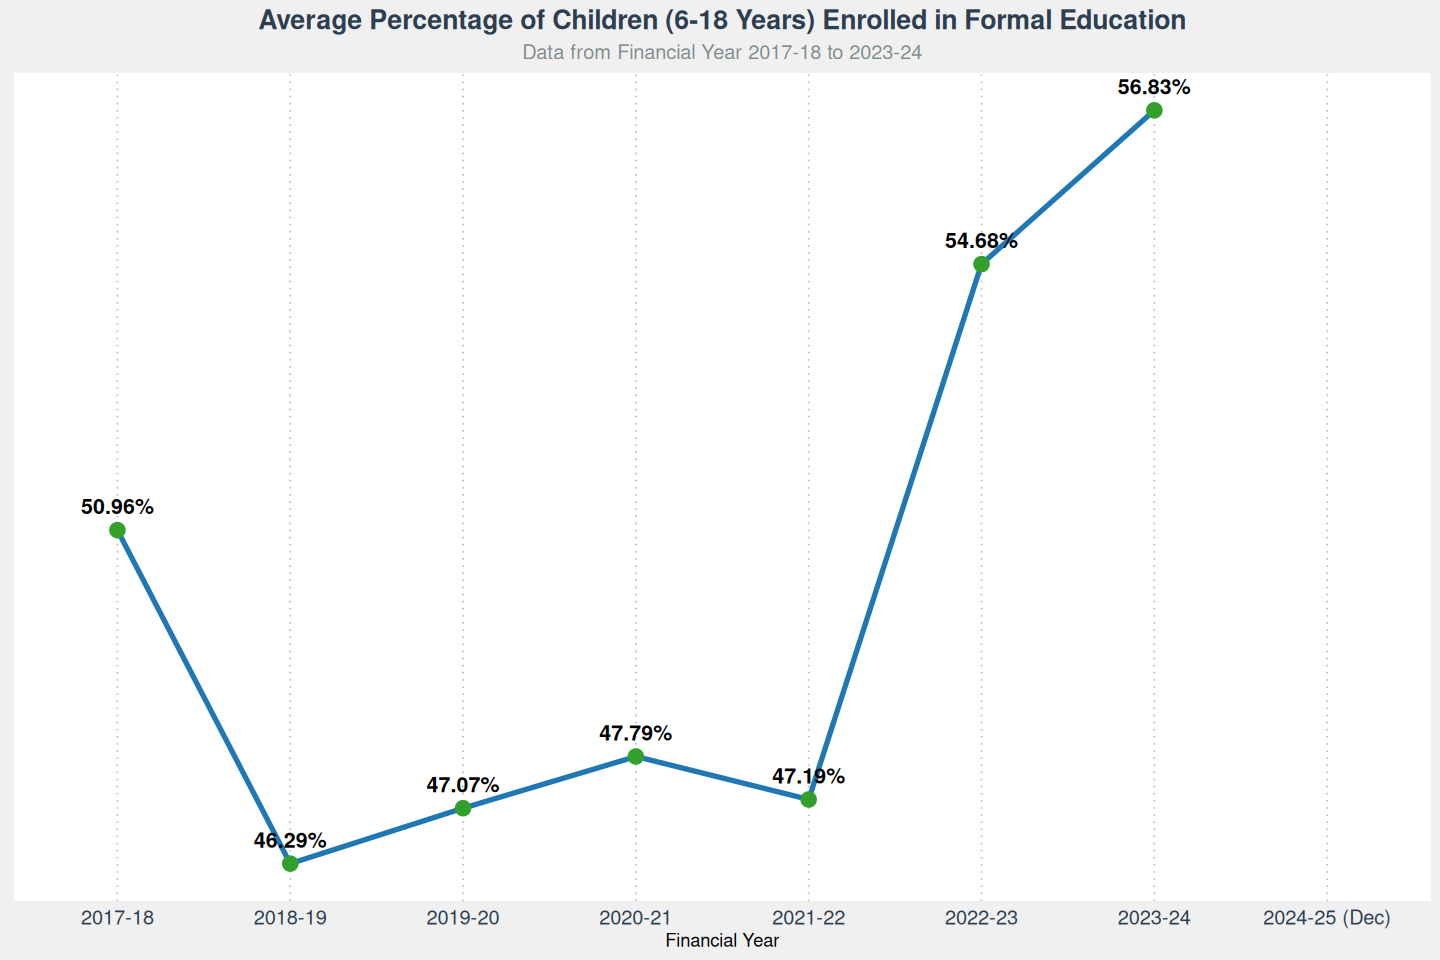

In [8]:
# Read the excel file with sheet name for children under purview
df_formal_edu <- read_excel(data_file, sheet = "FormalEdRatio")
df_formal_edu <- mutate(df_formal_edu, percentage = scales::percent(average))

# Create the line graph
ggplot(df_formal_edu, aes(x = FY, y = average, group = 1)) +
  geom_line(color = "#1f78b4", linewidth = 1.5) + # Use a blue color for the line
  geom_point(color = "#33a02c", size = 4) + # Use a green color for the points
  geom_text(
    aes(label = percentage),
    vjust = -1,
    size = 4.5,
    color = "black",
    fontface = "bold" # Make labels bold
  ) +
  labs(
    title = "Average Percentage of Children (6-18 Years) Enrolled in Formal Education",
    subtitle = "Data from Financial Year 2017-18 to 2023-24", # Add a subtitle
    x = "Financial Year",
    y = NULL # Remove y-axis label
  ) +
  theme_minimal() + # Use a minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold", color = "#2c3e50"), # Customize title
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "#7f8c8d"), # Customize subtitle
    plot.caption = element_text(hjust = 1, size = 10, color = "#7f8c8d"), # Customize caption
    axis.text.x = element_text(size = 12, color = "#2c3e50"), # Customize x-axis text
    axis.text.y = element_blank(), # Remove y-axis text
    axis.title.y = element_blank(), # Remove y-axis title
    axis.ticks.y = element_blank(), # Remove y-axis ticks
    axis.line.y = element_blank(), # Remove y-axis line
    panel.grid.major.x = element_line(color = "#bdc3c7", linetype = "dotted"), # Add dotted grid lines for x-axis
    panel.grid.minor.x = element_blank(), # Remove minor x-axis grid lines
    panel.grid.major.y = element_blank(), # Remove major y-axis grid lines
    panel.grid.minor.y = element_blank(), # Remove minor y-axis grid lines
    legend.position = "bottom", # Place the legend at the bottom
    plot.background = element_rect(fill = "#f0f0f0", color = NA), # Light gray background
    panel.background = element_rect(fill = "white", color = NA) # White panel background
  )


During pandemic hit years, Vocational Training Programs were vastly halted as access to CCIs was restricted, but these programs are resuming, and enrollment has also improved during this financial year.

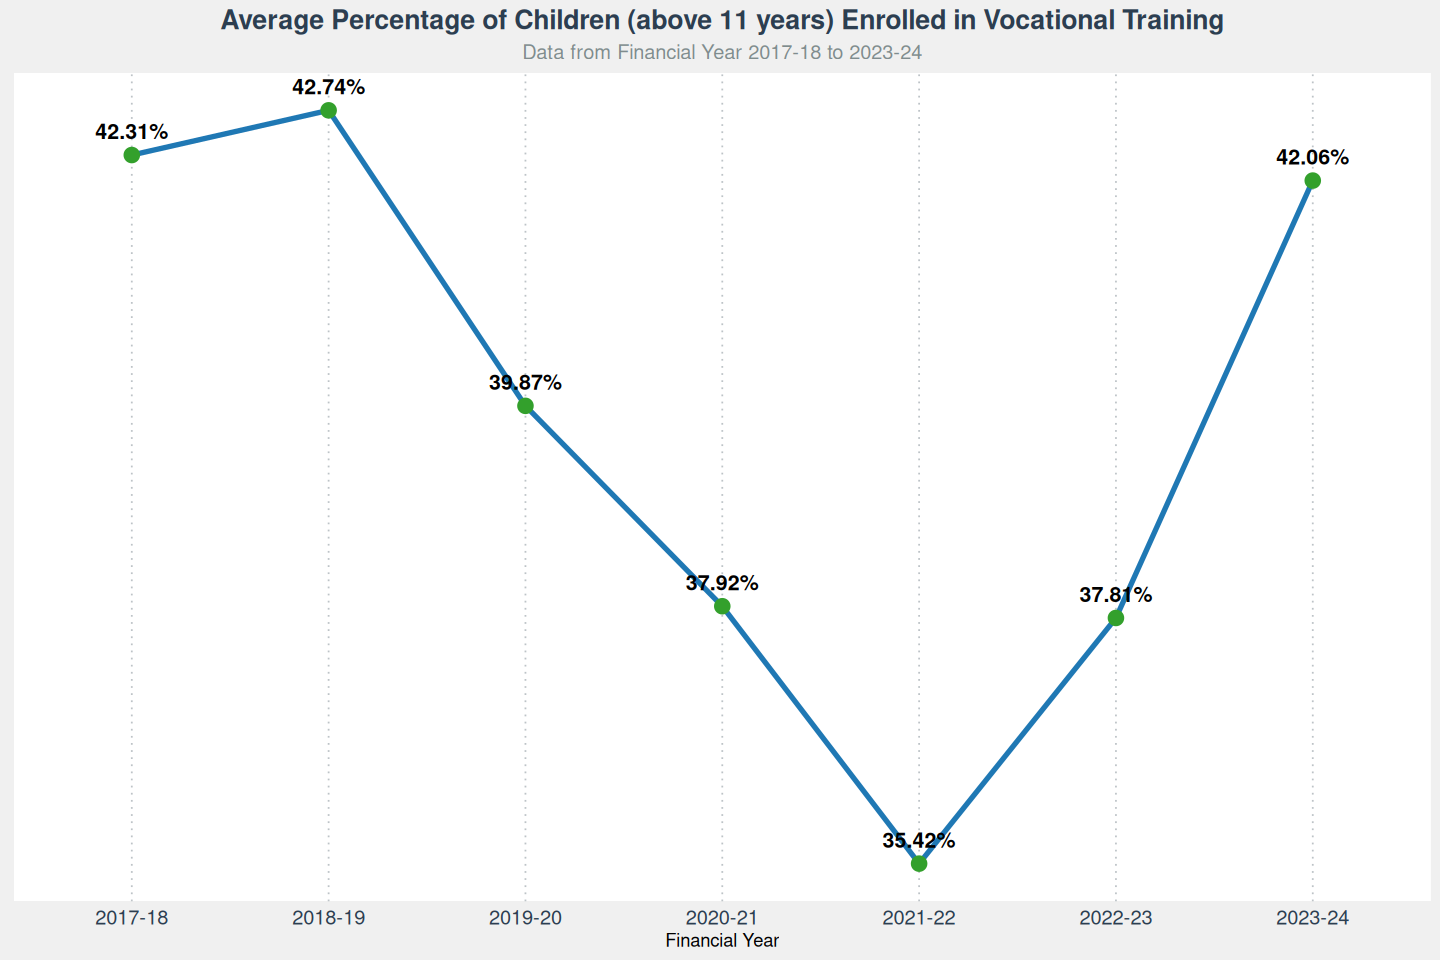

In [ ]:
# Read the excel file with sheet name for children under purview
df_vocational_edu <- read_excel(data_file, sheet = "VocationalTraining")
df_vocational_edu <- mutate(df_vocational_edu, percentage = scales::percent(average))

# Create the line graph
ggplot(df_vocational_edu, aes(x = FY, y = average, group = 1)) +
  geom_line(color = "#1f78b4", linewidth = 1.5) + # Use a blue color for the line
  geom_point(color = "#33a02c", size = 4) + # Use a green color for the points
  geom_text(
    aes(label = percentage),
    vjust = -1,
    size = 4.5,
    color = "black",
    fontface = "bold" # Make labels bold
  ) +
  labs(
    title = "Average Percentage of Children (above 11 years) Enrolled in Vocational Training",
    subtitle = "Data from Financial Year 2017-18 to 2023-24", # Add a subtitle
    x = "Financial Year",
    y = NULL # Remove y-axis label
  ) +
  theme_minimal() + # Use a minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold", color = "#2c3e50"), # Customize title
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "#7f8c8d"), # Customize subtitle
    plot.caption = element_text(hjust = 1, size = 10, color = "#7f8c8d"), # Customize caption
    axis.text.x = element_text(size = 12, color = "#2c3e50"), # Customize x-axis text
    axis.text.y = element_blank(), # Remove y-axis text
    axis.title.y = element_blank(), # Remove y-axis title
    axis.ticks.y = element_blank(), # Remove y-axis ticks
    axis.line.y = element_blank(), # Remove y-axis line
    panel.grid.major.x = element_line(color = "#bdc3c7", linetype = "dotted"), # Add dotted grid lines for x-axis
    panel.grid.minor.x = element_blank(), # Remove minor x-axis grid lines
    panel.grid.major.y = element_blank(), # Remove major y-axis grid lines
    panel.grid.minor.y = element_blank(), # Remove minor y-axis grid lines
    legend.position = "bottom", # Place the legend at the bottom
    plot.background = element_rect(fill = "#f0f0f0", color = NA), # Light gray background
    panel.background = element_rect(fill = "white", color = NA) # White panel background
  )
